# FIGURE 2

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from msresist.parameter_tuning import kmeansPLSR_tuning
from msresist.figures.figure2 import plotR2YQ2Y, plotKmeansPLSR_GridSearch, plotMeasuredVsPredicted, plotScoresLoadings, clusteraverages
from msresist.plsr import Q2Y_across_components, R2Y_across_components
from msresist.clustering import MyOwnKMEANS
from msresist.sequence_analysis import preprocess_seqs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from msresist.pre_processing import preprocessing, MergeDfbyMean
from msresist.FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")

### Importing and Pre-processing Data

### Phosphorylation measurements:

In [2]:
ABC_mc = preprocessing(motifs=True, Vfilter=True, FCfilter=True, log2T=True)
ABC_mc = preprocess_seqs(ABC_mc, "Y")


header = ABC_mc.columns
treatments = ABC_mc.columns[3:13]

data = ABC_mc.iloc[:,3:13].T
protnames = list(ABC_mc.iloc[:,1])
seqs = list(ABC_mc.iloc[:,0])

In [3]:
ABC_mc.sort_values(by="Master Protein Descriptions")

,peptide-phosphosite,Master Protein Descriptions,Master_Protein_Accessions,PC9,Erl,R428,Erl/R428,Erl+HGF,Erl+FGF,Erl+IGF,KO Erl,KO R428,KO Erl/R428,position
542,RNPGFyVEANP,"1-phosphatidylinositol 4,5-bisphosphate phosph...",P19174,0.891610,-0.132290,0.508638,-0.431225,-0.008149,0.338497,-0.481326,-0.713501,0.547278,-0.519532,Y783-p
203,GDYHRyLAEFA,14-3-3 protein epsilon,P62258,0.413272,0.620284,0.352508,-0.291815,0.122734,0.216532,0.167650,-0.586405,-0.395571,-0.619189,Y131-p
381,LLSVAyKNVVG,14-3-3 protein zeta/delta,P63104,2.028584,1.620221,1.301309,-0.568873,-0.712916,-0.731959,-0.791261,-0.762381,-0.574292,-0.808433,Y48-p
657,TYELRyFQISQ,60S ribosomal protein L22-like 1,Q6P5R6,-0.050440,-0.157775,-0.042431,0.073614,-0.466527,-0.151340,0.006562,-0.384522,1.342117,-0.169258,Y108-p
350,KtTLLyKLKGH,ADP-ribosylation factor-like protein 11,Q969Q4,0.524947,0.122358,0.153717,-0.546423,0.213311,-0.225130,-0.111816,-0.105150,0.030002,-0.055816,Y30-p
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,LLSSDyRIING,Zinc finger CCCH-type antiviral protein 1,Q7Z2W4,2.169358,1.570918,0.620437,-1.374179,0.289226,-0.012489,0.232086,-0.981527,-1.024902,-1.488927,Y410-p
197,GALADyEGKDV,Zinc finger protein 185,O15231,1.316789,0.388504,0.263724,-1.455803,0.597152,0.022433,0.432893,-0.449084,-0.012254,-1.104353,Y408-p
482,PVSARySNVSS,Zinc finger protein 185,O15231,0.577963,0.026361,0.046690,0.203022,0.399508,0.017095,-0.176009,-0.181494,-0.215097,-0.698038,Y597-p
362,LFVKEyVNASE,Zinc finger protein 185,O15231,2.694753,0.852521,0.959014,-1.434426,0.582779,-0.266371,-0.040972,-1.194264,-0.760311,-1.392723,Y581-p


### Phenotypes

#### Cell Viability:

In [4]:
Y_cv1 = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw3.csv').iloc[:30, :11]
Y_cv2 = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw4.csv').iloc[:29, :11]

for ii in range(1, Y_cv2.columns.size):
    Y_cv1.iloc[:, ii] /= Y_cv1.iloc[0, ii]
    Y_cv2.iloc[:, ii] /= Y_cv2.iloc[0, ii]

Y_cv = MergeDfbyMean(pd.concat([Y_cv1, Y_cv2], axis=0), Y_cv1.columns, "Elapsed")
Y_cv = Y_cv.reset_index()[Y_cv1.columns]
Y_cv = Y_cv[Y_cv["Elapsed"] == 72].iloc[0, 1:]

## 1. Cross-validation

### 1.1 Strategy 1: R2Y/Q2Y after k-means clustering (k=5)

Cross-validation fitting averages of k-means clusters into the PLSR model. Number of clusters must be set in advance:

In [5]:
ncl = 2

In [6]:
kmeans = MyOwnKMEANS(ncl).fit(data, Y_cv)
centers = kmeans.transform(data)

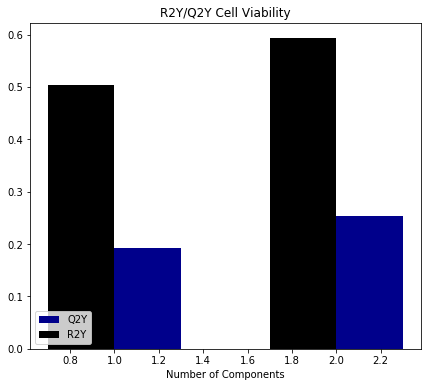

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
plotR2YQ2Y(ax, ncl, centers, Y_cv)

### 1.2 Strategy 2: Gridsearch

Cross-validation fitting averages of k-means clusters into the PLSR model. Simulatenous tuning of number of clusters and number of components using GridSearch:

In [8]:
# fig, ax = plt.subplots(1, 1)
# plotKmeansPLSR_GridSearch(ax, data, Y_cv)

In [9]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

# CVresults_max, CVresults_min, best_params = kmeansPLSR_tuning(data, Y_cv)

In [10]:
# CVresults_min.sort_values(by="Ranking").iloc[:20, :]

## 2. Model Predicted vs Actual for best Hyperparameter Set

In [11]:
ncl, ncomp = 2, 2

### 2.1 With CV Strategy 1:

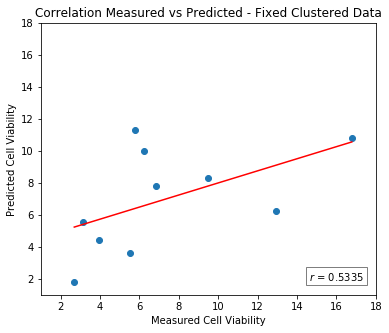

In [12]:
fig, ax = plt.subplots(1,1,figsize=(6,5))

plotMeasuredVsPredicted(ax, PLSRegression(ncomp), centers, Y_cv)
plt.title("Correlation Measured vs Predicted - Fixed Clustered Data");

### 2.2 With CV Strategy 2:

In [13]:
estimators = [('kmeans', MyOwnKMEANS(ncl)), ('plsr', PLSRegression(ncomp))]
kmeans_plsr = Pipeline(estimators)

In [14]:
X_scores, Y_scores = kmeans_plsr.fit_transform(data, Y_cv)
PC1_scores, PC2_scores = X_scores[:, 0], X_scores[:, 1]
PC1_xload, PC2_xload = kmeans_plsr.named_steps.plsr.x_loadings_[:, 0], kmeans_plsr.named_steps.plsr.x_loadings_[:, 1]
PC1_yload, PC2_yload = kmeans_plsr.named_steps.plsr.y_loadings_[:, 0], kmeans_plsr.named_steps.plsr.y_loadings_[:, 1]

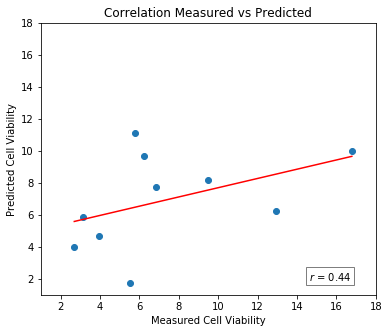

In [15]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
plotMeasuredVsPredicted(ax, kmeans_plsr, data, Y_cv)

## 3. PLSR scores and loadings 

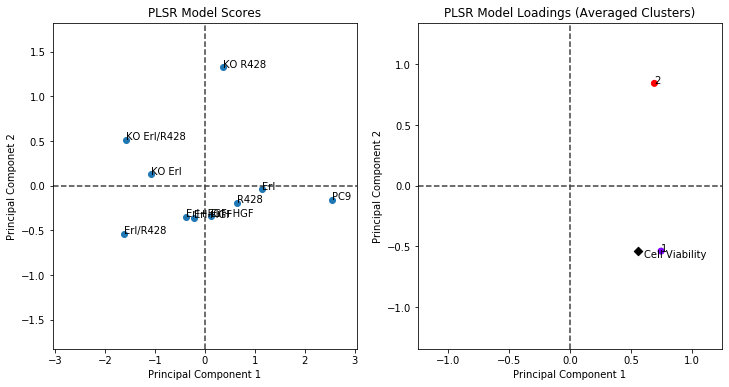

In [16]:
fig, axs = plt.subplots(1, 2,figsize=(12,6))

colors_ = cm.rainbow(np.linspace(0, 1, ncl))


axs[0].scatter(PC1_scores,PC2_scores)
for j, txt in enumerate(treatments):
    axs[0].annotate(txt, (PC1_scores[j], PC2_scores[j]))
axs[0].set_title('PLSR Model Scores')
axs[0].set_xlabel('Principal Component 1')
axs[0].set_ylabel('Principal Componet 2')
axs[0].axhline(y=0, color='0.25', linestyle='--')
axs[0].axvline(x=0, color='0.25', linestyle='--')
spacer = 0.5
axs[0].set_xlim([(-1*max(PC1_scores))-spacer, max(PC1_scores)+spacer])
axs[0].set_ylim([(-1*max(PC2_scores))-spacer, max(PC2_scores)+spacer])

numbered=[]
list(map(lambda v: numbered.append(str(v+1)), range(ncl)))

for i, txt in enumerate(numbered):
    axs[1].annotate(txt, (PC1_xload[i], PC2_xload[i]))
axs[1].annotate("Cell Viability", (PC1_yload+0.05, PC2_yload-0.05))
axs[1].scatter(PC1_xload, PC2_xload, c=np.arange(ncl), cmap=colors.ListedColormap(colors_))
axs[1].scatter(PC1_yload, PC2_yload, color='#000000', marker='D', label='Cell Viability')
axs[1].set_title('PLSR Model Loadings (Averaged Clusters)')
axs[1].set_xlabel('Principal Component 1')
axs[1].set_ylabel('Principal Component 2')
axs[1].axhline(y=0, color='0.25', linestyle='--')
axs[1].axvline(x=0, color='0.25', linestyle='--')
axs[1].set_xlim([(-1*max(list(PC1_xload)+list(PC1_yload)))-spacer, max(list(PC1_xload)+list(PC1_yload))+spacer])
axs[1].set_ylim([(-1*max(list(PC2_xload)+list(PC2_yload)))-spacer, max(list(PC2_xload)+list(PC2_yload))+spacer]);

In [17]:
clustermembers = kmeans_plsr.named_steps.kmeans.clustermembers(ABC_mc.T)
clustermembers

,Cluster_1,seqs_Cluster_1,ProtAcc_Cluster_1,pos_Cluster_1,Cluster_2,seqs_Cluster_2,ProtAcc_Cluster_2,pos_Cluster_2
0,Coactosin-like protein,ACRAAyNLVRD,Q14019,Y14-p,Heat shock 70 kDa protein 1A,AAAIAyGLDRT,P0DMV8,Y183-p
1,Receptor tyrosine-protein kinase erbB-2,AENPEyLGLDV,P04626,Y1248-p,"Adenylate kinase 2, mitochondrial",AAEPEyPKGIR,P54819,Y12-p
2,ATPase WRNIP1,AGEEHyNCISA,Q96S55,Y500-p,DNA replication licensing factor MCM7,AANPAyGRYNP,P33993,Y492-p
3,Transgelin-2,AGMTGyGMPRQ,P37802,Y192-p,Pyruvate kinase PKM,AEAAIyHLQLF,P14618,Y390-p
4,Protein tweety homolog 3,AHDSLyRVHMP,Q9C0H2,Y439-p,Envoplakin,AEDAVyELQSK,Q92817,Y1352-p
5,Aldo-keto reductase family 1 member B1,AIDVGyRHIDC,P15121,Y40-p,Kinesin light chain 2,AEEVEyYYRRA,Q9H0B6,Y345-p
6,Nucleophosmin,AKFINyVKNCF,P06748,Y271-p,Protein-glutamine gamma-glutamyltransferase 2,AERDLyLENPE,P21980,Y583-p
7,Receptor tyrosine-protein kinase erbB-3,APHVHyARLKT,P21860,Y1307-p,ADP/ATP translocase 2,ANVIRyFPTQA,P05141,Y81-p
8,Tubulin-folding cofactor B,ARLGEyEDVSR,Q99426,Y98-p,Ras and Rab interactor 1,AQDPLyDVPNA,Q13671,Y36-p
9,Perilipin-3,ASASEyAHRGL,O60664,Y95-p,Receptor tyrosine-protein kinase erbB-3,ASEQGyEEMRA,P21860,Y1289-p


#### Cluster Averages across Conditions

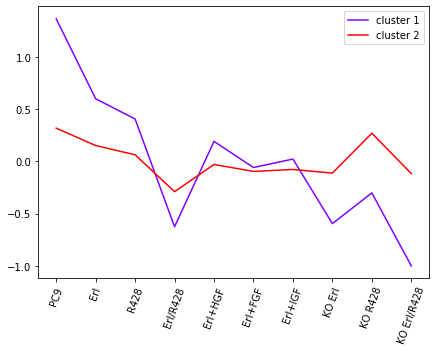

In [18]:
fig = plt.figure(figsize=(7,5))

centers = kmeans_plsr.named_steps.kmeans.transform(data).T

for i in range(centers.shape[0]):
    plt.plot(centers.iloc[i,:], label = "cluster "+str(i+1), color = colors_[i])
    
plt.legend()
plt.xticks(np.arange(centers.shape[1]), (treatments), rotation=70);